# 現象数理モデル論　課題A

待ち行列のシミュレーションを行う．以下，配布されたアルゴリズムをJulia言語で実装したものである．実行環境は以下のとおり

- MacBook Pro Early2015
- Intel Core i7 3.1GHz
- macOS Catalina 10.15.1

In [1]:
using Plots, Random

┌ Info: Recompiling stale cache file /Users/mickn/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


In [2]:
"""アルゴリズムAの移植"""
const rnd = MersenneTwister(123)      # 再現性のためにシード固定
const T₀ = 1000
const Tₑ = 1110000

1110000

In [3]:
const ρ_thm = collect(0:0.01:0.95)
const μ = [1., 0.5, 0.01]
const mesh = 20

20

In [4]:
λmesh(mu, mesh) = collect(0:mu/mesh:mu)
λ1 = λmesh(μ[1], mesh)
λ2 = λmesh(μ[2], mesh)
λ3 = λmesh(μ[3], mesh)
Ns_thm(ρ) = ρ/(1-ρ)

Ns_thm (generic function with 1 method)

In [5]:
function QueueNs(λ, μ)
    Ns = zeros(length(λ))
    for (i, Lambda) in enumerate(λ)
        # 滞在人数
        n = 0
        # 滞在人数の累積
        nSum = 0

        # タイムステップのループ
        for t in 0:Tₑ
            # サービス
            if n>0
                (Random.rand!(rnd, zeros(1))[1]<μ) && (n -= 1)
            end
            # 到着
            (Random.rand!(rnd, zeros(1))[1]<Lambda) && (n += 1)
            # 記録
            (t>=T₀) && (nSum += n)
        end
        Ns[i] = nSum / (Tₑ - T₀)
    end
    return Ns
end

QueueNs (generic function with 1 method)

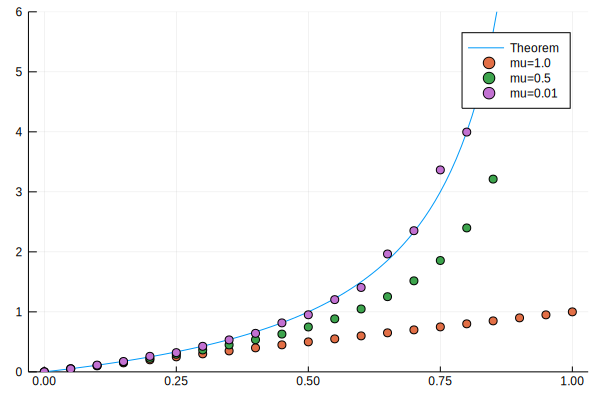

In [6]:
plot(ρ_thm, Ns_thm.(ρ_thm), label="Theorem")
scatter!(λ1/μ[1], QueueNs(λ1, μ[1]), label="mu=1.0")
scatter!(λ2/μ[2], QueueNs(λ2, μ[2]), label="mu=0.5")
scatter!(λ3/μ[3], QueueNs(λ3, μ[3]), label="mu=0.01")
ylims!((0, 6))

#### 課題１
$\mu=0$に近づくにつれて，理論曲線に漸近しており，シミュレーションが正しくないことがわかる．これは，確率的な連続時間のモデルである `M/M/1` 待ち行列の状態更新について，各時間ステップで確定的に到着とサービス判定を行う離散時間的なパラレルアップデートを用いているためだと考えられる．

#### 課題２
連続的な微分方程式をシミュレートできるランダムアップデートを到着とサービスについて実施することで正しいシミュレートを行うことができると予想される．課題３においてはこれを実装した．

また，到着レートとサービスレートを考えると，局所的な増加率は時間同期して確率判定を行っているため，１を絶対に超えない．一方で，実際には局所的には１を超えることもありうる．従って，時刻同期な確率判定ではなく，微小時間ごとに判定を行うようにパラレルアップデートを改良することでもアルゴリズムを実装できると考えられる．

また，待っている人に着目して粒子法的に各粒子の平均滞在時間を計算してリトルの公式より平均滞在人数を計算する方法も考えられる．

#### 課題３

改良したアルゴリズムは以下のとおりである．

In [7]:
function QueueNsMod(λ, μ)
    Ns = zeros(length(λ))
    for (i, Lambda) in enumerate(λ)
        # 滞在人数
        n = 0
        # 滞在人数の累積
        nSum = 0

        # タイムステップのループ
        for t in 0:Tₑ
            if (Random.rand!(rnd, zeros(1))[1]<0.5)
                # 到着
                (Random.rand!(rnd, zeros(1))[1]<Lambda) && (n += 1)
            else
                # サービス
                if n>0
                    (Random.rand!(rnd, zeros(1))[1]<μ) && (n -= 1)
                end
            end
            # 記録
            (t>=T₀) && (nSum += n)
        end
        Ns[i] = nSum / (Tₑ - T₀)
#         Ns[i] = n
    end
    return Ns
end
# 到着とサービスは同期していてはだめ！！

QueueNsMod (generic function with 1 method)

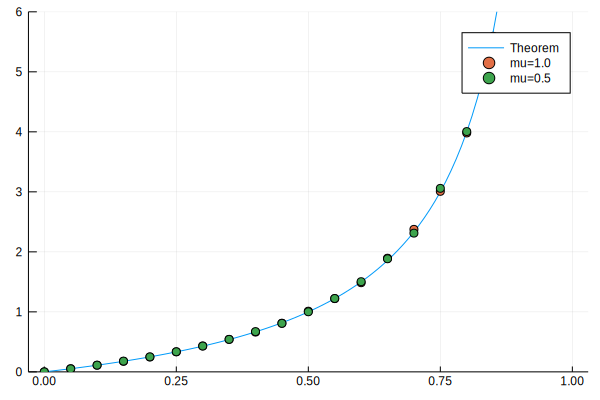

In [8]:
plot(ρ_thm, Ns_thm.(ρ_thm), label="Theorem")
scatter!(λ1/μ[1], QueueNsMod(λ1, μ[1]), label="mu=1.0")
scatter!(λ2/μ[2], QueueNsMod(λ2, μ[2]), label="mu=0.5")
ylims!((0, 6))

上グラフのように，理論曲線を再現できることがわかる．